In [40]:
import pandas as pd

In [41]:
df = pd.read_csv("20181229_fut_ord.csv", low_memory=False, dtype={'SYMBOL':object,
                                                                  'SYSTEM':object,
                                                                  'TYPE':object,
                                                                  'MOMENT':int,
                                                                  'ID':object,
                                                                  'ACTION':object,
                                                                  'PRICE':object,
                                                                  'VOLUME':object,
                                                                  'ID_DEAL':object,
                                                                  'PRICE_DEAL':object
                                                                  })

In [8]:
df.head()

,SYMBOL,SYSTEM,TYPE,MOMENT,ID,ACTION,PRICE,VOLUME,ID_DEAL,PRICE_DEAL
0,GZM9,F,B,20181228185033900,33948174935,1,14092.00000,2,NaN,NaN
1,GZM9,F,B,20181228185033907,33948174936,1,14208.00000,1,NaN,NaN
2,SAH9,F,B,20181228185033913,33948174939,1,14.78000,10,NaN,NaN
3,GZH9,F,B,20181228185033920,33948174941,1,14351.00000,1,NaN,NaN
4,GZH9,F,B,20181228185033920,33948174942,1,14303.00000,1,NaN,NaN


In [42]:
df = df.drop(columns=['SYSTEM', 'ID_DEAL', 'PRICE_DEAL'])

In [43]:
df.to_csv('20181229_fut_ord_changed.csv', index=False)

In [13]:
import seaborn as sns

<Axes: xlabel='MOMENT', ylabel='Count'>

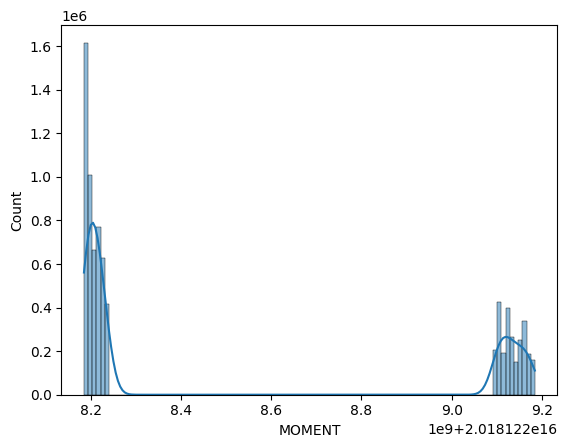

In [21]:
sns.histplot(data = df.MOMENT, kde = True)

In [44]:
import datetime
from datetime import timedelta

In [55]:
# нужно подкорректировать т. не совсем ясно во сколько начинаются торги
def create_ddl_partition_table(year, month, day, df):
    date_start = datetime.date(year=year, month=month, day=day)
    moment_start = str(date_start.year) + str(date_start.month) + str(date_start.day) + "000000000"
    delta = timedelta(days=1)
    date_end = date_start+delta
    moment_end = str(date_end.year) + str(date_end.month) + str(date_start.day) + "235959999"

    CREATE_PARTITION_DAY_TABLE = f"""CREATE TABLE current_rate_y{year}m{month}d{day}
                                PARTITION OF current_rate 
                                FOR VALUES FROM ({moment_start}) TO ({moment_end})
                                PARTITION BY LIST (tool);"""
    result_ddl_query = CREATE_PARTITION_DAY_TABLE + "\n"
    tools = df.SYMBOL.unique()
    for tool in tools:
        # создание партиционированных таблиц по типу инструмента
        CREATE_PARTITION_TOOL_TABLE = f"""CREATE TABLE current_rate_y{year}m{month}d{day}_{tool} 
                                    PARTITION OF current_rate_y{year}m{month}d{day} 
                                    FOR VALUES IN ('{tool}');"""
        # создание индекса для поиска по id заявки
        CREATE_PARTITION_TOOL_TABLE_INDEX =f"""CREATE INDEX ON current_rate_y{year}m{month}d{day}_{tool} (id_request);"""
        result_ddl_query = result_ddl_query + CREATE_PARTITION_TOOL_TABLE + "\n" \
                         + CREATE_PARTITION_TOOL_TABLE_INDEX + "\n"

    # Open the file for writing
    with open(f"""sql_scripts/partition_table_y{year}m{month}d{day}.sql""", 'w') as f:
        f.write(result_ddl_query)

In [56]:
create_ddl_partition_table(2018, 12, 28, df)
create_ddl_partition_table(2018, 12, 29, df)
